In [155]:
import pandas as pd
import math
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer


warnings.filterwarnings(action='ignore')

data = []
with open('chronic_kidney_disease.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class']
    
df = pd.DataFrame(data, columns=names)

In [156]:
df=df.replace('?', math.nan)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [157]:
cols=['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')


In [158]:
# Extracting categorical and numerical columns
categorical_df=[]
numerical_df=[]
for col in df.columns:
    if df[col].dtype=='object':
        categorical_df.append(col)
    if df[col].dtype=='float64':
        numerical_df.append(col)

In [159]:
for col in categorical_df:
    print(f"{col} has {df[col].unique()} values\n")

rbc has [nan 'normal' 'abnormal'] values

pc has ['normal' 'abnormal' nan] values

pcc has ['notpresent' 'present' nan] values

ba has ['notpresent' 'present' nan] values

htn has ['yes' 'no' nan] values

dm has ['yes' 'no' ' yes' '\tno' nan] values

cad has ['no' 'yes' nan] values

appet has ['good' 'poor' nan] values

pe has ['no' 'yes' nan] values

ane has ['no' 'yes' nan] values

class has ['ckd' 'ckd\t' 'notckd'] values



In [160]:
# replace incorrect values

df['dm'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)

df['cad'] = df['cad'].replace(to_replace = '\tno', value='no')

df['class'] = df['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

In [161]:
df.isna().sum().sort_values(ascending = False)


rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [162]:
# le = preprocessing.LabelEncoder()
# df = df.apply(lambda series: pd.Series(
#     le.fit_transform(series[series.notnull()]),
#     index=series[series.notnull()].index
# ))

In [163]:
categ_df=df[categorical_df]
normam_df=df[numerical_df]

In [164]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
dd=imputer.fit_transform(categ_df)
categ_df = pd.DataFrame(dd, columns = categorical_df)
categ_df.tail()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
395,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
396,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
397,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
398,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd
399,normal,normal,notpresent,notpresent,no,no,no,good,no,no,not ckd


In [165]:
frames = [ categ_df,normam_df]
new_data=pd.concat(frames)
df = pd.concat([normam_df, categ_df], axis=1)

In [166]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [167]:
label_encoder = preprocessing.LabelEncoder()
for i  in categorical_df:
    df[i]= label_encoder.fit_transform(df[i])

In [168]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


<Figure size 432x288 with 0 Axes>

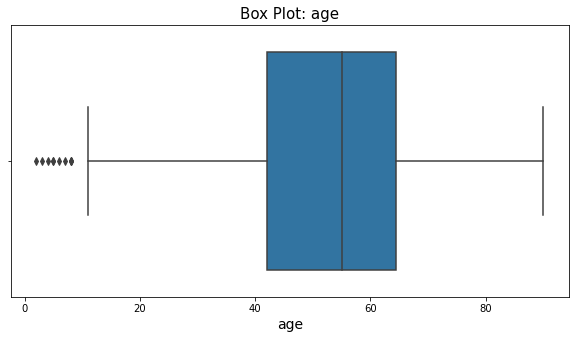

<Figure size 432x288 with 0 Axes>

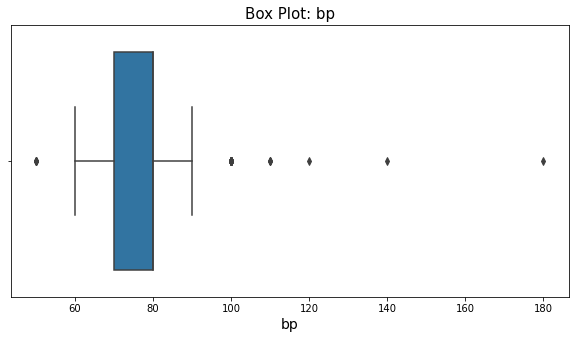

<Figure size 432x288 with 0 Axes>

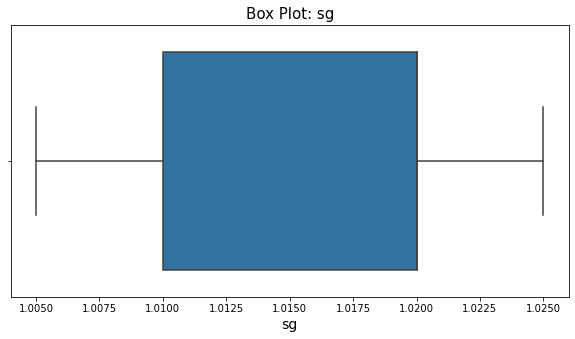

<Figure size 432x288 with 0 Axes>

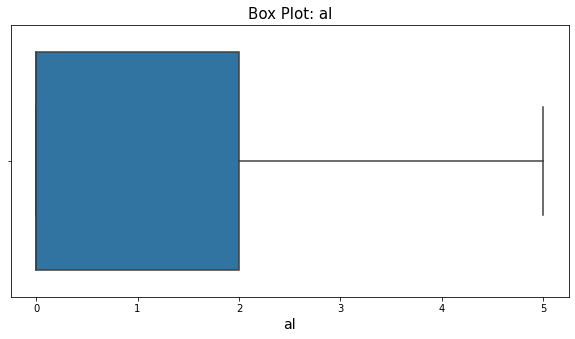

<Figure size 432x288 with 0 Axes>

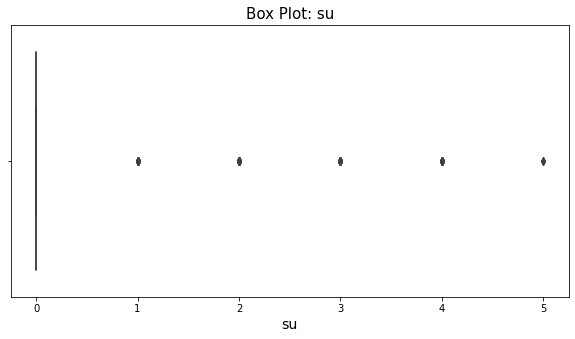

<Figure size 432x288 with 0 Axes>

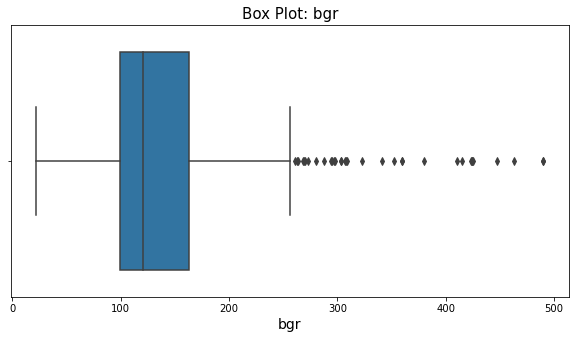

<Figure size 432x288 with 0 Axes>

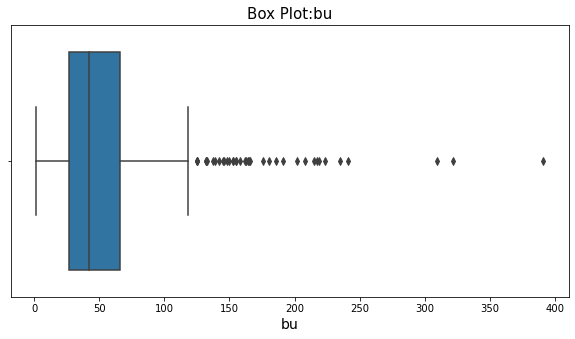

<Figure size 432x288 with 0 Axes>

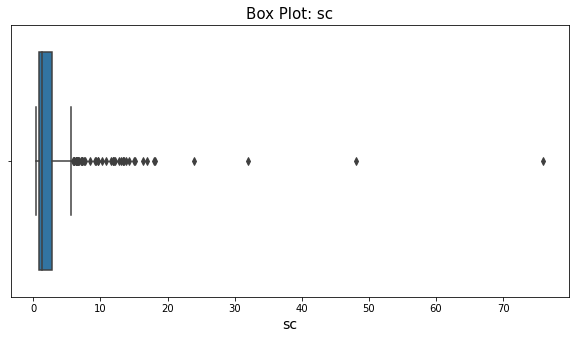

<Figure size 432x288 with 0 Axes>

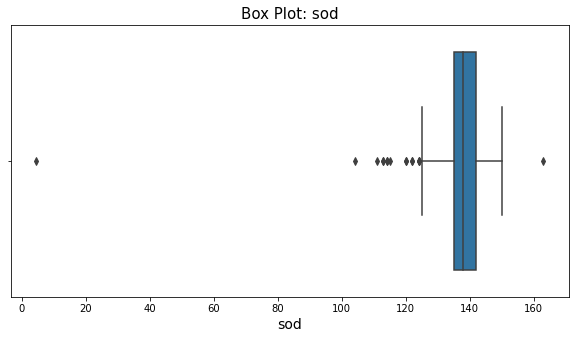

<Figure size 432x288 with 0 Axes>

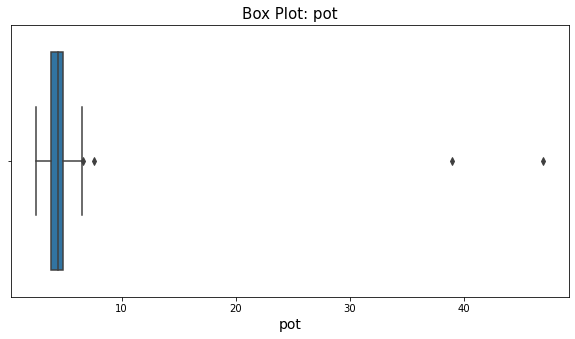

<Figure size 432x288 with 0 Axes>

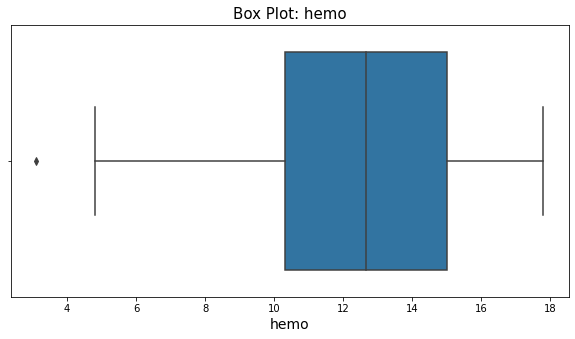

<Figure size 432x288 with 0 Axes>

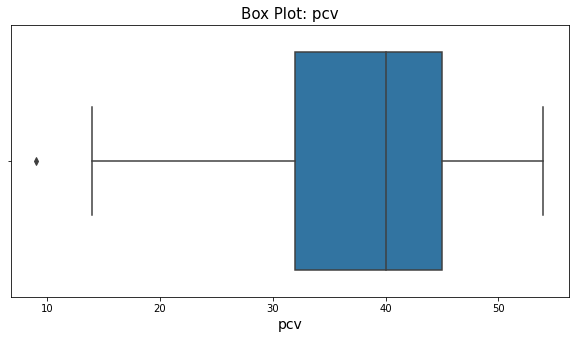

<Figure size 432x288 with 0 Axes>

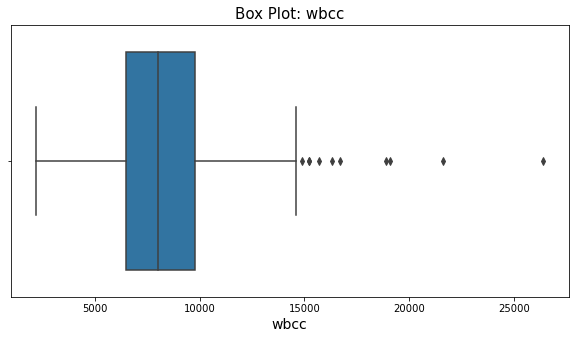

<Figure size 432x288 with 0 Axes>

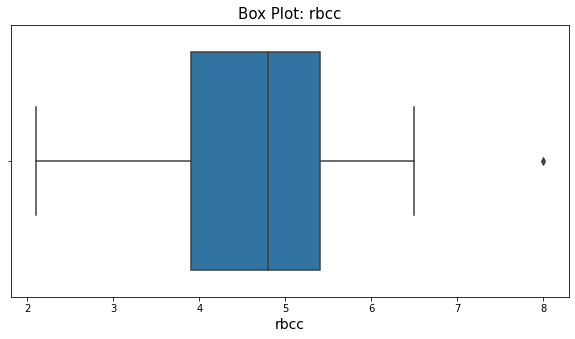

In [169]:
new_data=df
plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['age'])
plt.title('Box Plot: age', fontsize=15)
plt.xlabel('age', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bp'])
plt.title('Box Plot: bp', fontsize=15)
plt.xlabel('bp', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sg'])
plt.title('Box Plot: sg', fontsize=15)
plt.xlabel('sg', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['al'])
plt.title('Box Plot: al', fontsize=15)
plt.xlabel('al', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['su'])
plt.title('Box Plot: su', fontsize=15)
plt.xlabel('su', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bgr'])
plt.title('Box Plot: bgr', fontsize=15)
plt.xlabel('bgr', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bu'])
plt.title('Box Plot:bu', fontsize=15)
plt.xlabel('bu', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sc'])
plt.title('Box Plot: sc', fontsize=15)
plt.xlabel('sc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sod'])
plt.title('Box Plot: sod', fontsize=15)
plt.xlabel('sod', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pot'])
plt.title('Box Plot: pot', fontsize=15)
plt.xlabel('pot', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['hemo'])
plt.title('Box Plot: hemo', fontsize=15)
plt.xlabel('hemo', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pcv'])
plt.title('Box Plot: pcv', fontsize=15)
plt.xlabel('pcv', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['wbcc'])
plt.title('Box Plot: wbcc', fontsize=15)
plt.xlabel('wbcc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['rbcc'])
plt.title('Box Plot: rbcc', fontsize=15)
plt.xlabel('rbcc', fontsize=14)
plt.show()







In [170]:
from sklearn.impute import KNNImputer

In [171]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [172]:
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [173]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [174]:
def optimize_k(data, target):
    errors = []
    for k in range(1, 20):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [175]:
k_errors = optimize_k(data=df, target='class')
print(k_errors)

[{'K': 1, 'RMSE': 0.08714929718592113}, {'K': 2, 'RMSE': 0.09444575162494076}, {'K': 3, 'RMSE': 0.10821275340735029}, {'K': 4, 'RMSE': 0.11430952132988165}, {'K': 5, 'RMSE': 0.12374368670764582}, {'K': 6, 'RMSE': 0.1230616376726178}, {'K': 7, 'RMSE': 0.11926511085253166}, {'K': 8, 'RMSE': 0.12096487093367231}, {'K': 9, 'RMSE': 0.12936382802004587}, {'K': 10, 'RMSE': 0.12267164844956364}, {'K': 11, 'RMSE': 0.12497999839974394}, {'K': 12, 'RMSE': 0.13112017388640088}, {'K': 13, 'RMSE': 0.1270170592217177}, {'K': 14, 'RMSE': 0.12519318405301996}, {'K': 15, 'RMSE': 0.12886685635440429}, {'K': 16, 'RMSE': 0.12300067750490916}, {'K': 17, 'RMSE': 0.1171501885046143}, {'K': 18, 'RMSE': 0.1257079949724758}, {'K': 19, 'RMSE': 0.12315302134607443}]


In [176]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [177]:
#akal wahda fiha error 1 donc bech nekhdmou knn bel 1
KNN=KNNImputer(weights='distance', n_neighbors=3)
data_after_knn=KNN.fit_transform(df)
df=pd.DataFrame(data_after_knn,columns=df.columns)


In [178]:
df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,138.794403,4.481559,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,107.005594,18.0,0.8,137.674750,3.773504,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,132.000000,4.400633,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,138.031282,4.260403,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 432x288 with 0 Axes>

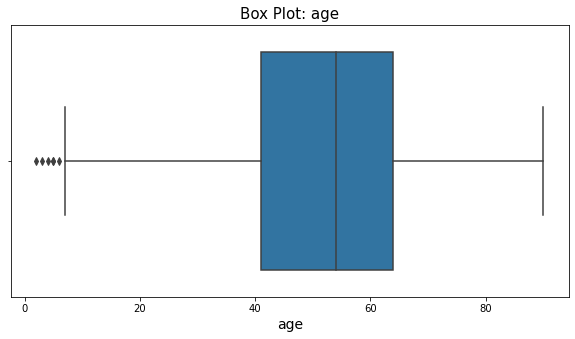

<Figure size 432x288 with 0 Axes>

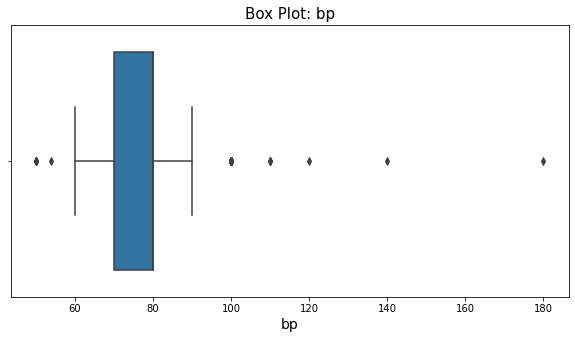

<Figure size 432x288 with 0 Axes>

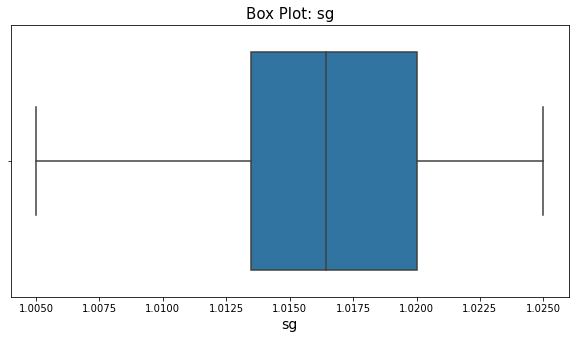

<Figure size 432x288 with 0 Axes>

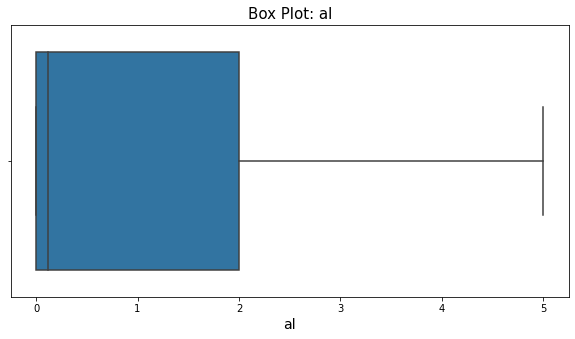

<Figure size 432x288 with 0 Axes>

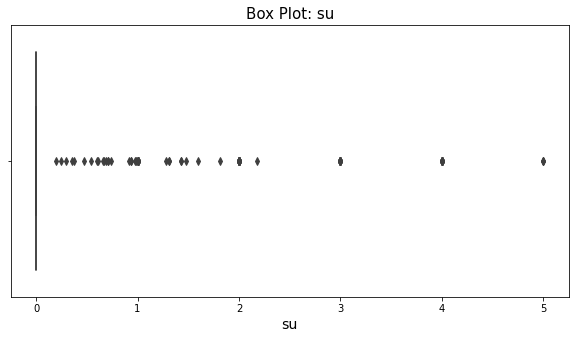

<Figure size 432x288 with 0 Axes>

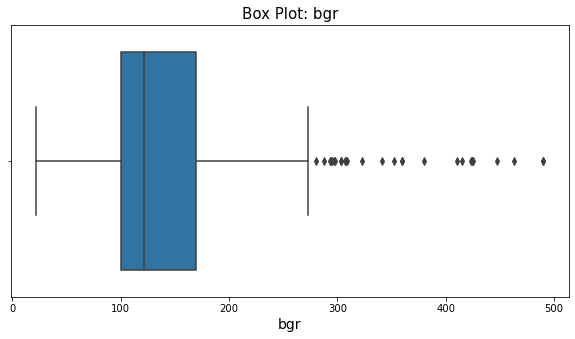

<Figure size 432x288 with 0 Axes>

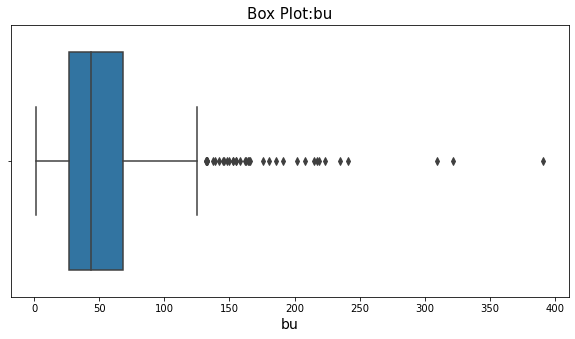

<Figure size 432x288 with 0 Axes>

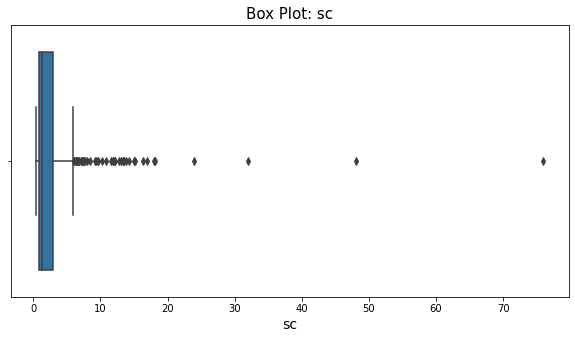

<Figure size 432x288 with 0 Axes>

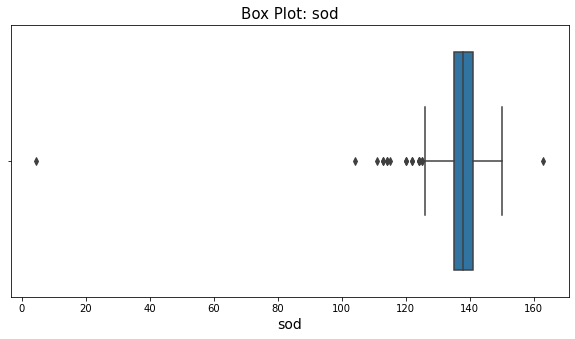

<Figure size 432x288 with 0 Axes>

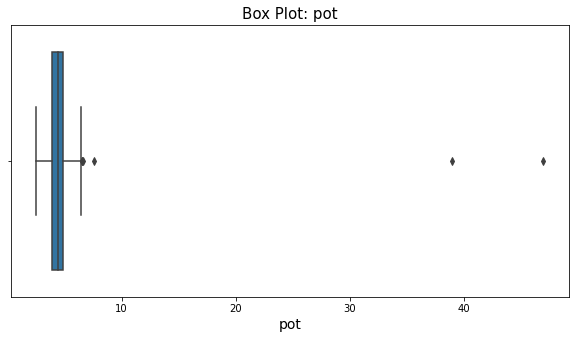

<Figure size 432x288 with 0 Axes>

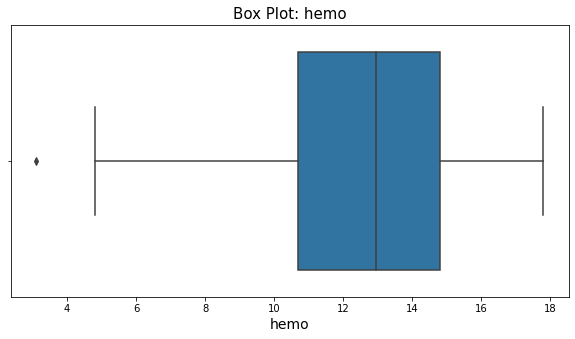

<Figure size 432x288 with 0 Axes>

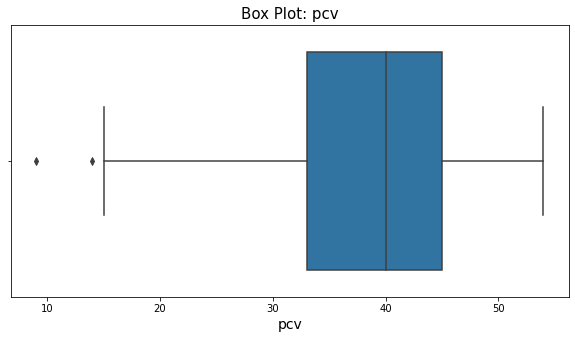

<Figure size 432x288 with 0 Axes>

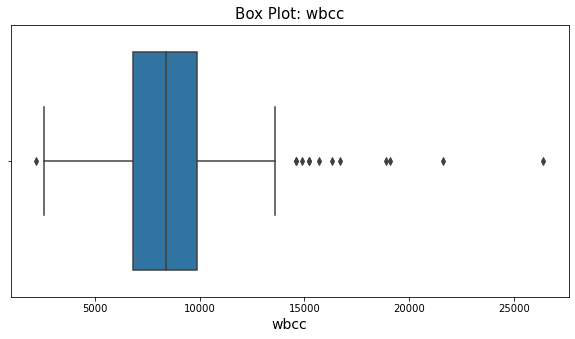

<Figure size 432x288 with 0 Axes>

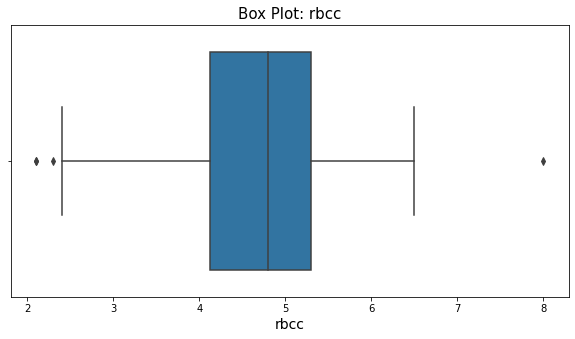

In [179]:
new_data=df
plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['age'])
plt.title('Box Plot: age', fontsize=15)
plt.xlabel('age', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bp'])
plt.title('Box Plot: bp', fontsize=15)
plt.xlabel('bp', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sg'])
plt.title('Box Plot: sg', fontsize=15)
plt.xlabel('sg', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['al'])
plt.title('Box Plot: al', fontsize=15)
plt.xlabel('al', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['su'])
plt.title('Box Plot: su', fontsize=15)
plt.xlabel('su', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bgr'])
plt.title('Box Plot: bgr', fontsize=15)
plt.xlabel('bgr', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['bu'])
plt.title('Box Plot:bu', fontsize=15)
plt.xlabel('bu', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sc'])
plt.title('Box Plot: sc', fontsize=15)
plt.xlabel('sc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['sod'])
plt.title('Box Plot: sod', fontsize=15)
plt.xlabel('sod', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pot'])
plt.title('Box Plot: pot', fontsize=15)
plt.xlabel('pot', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['hemo'])
plt.title('Box Plot: hemo', fontsize=15)
plt.xlabel('hemo', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['pcv'])
plt.title('Box Plot: pcv', fontsize=15)
plt.xlabel('pcv', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['wbcc'])
plt.title('Box Plot: wbcc', fontsize=15)
plt.xlabel('wbcc', fontsize=14)
plt.show()

plt.figure(7)
fig = plt.figure(figsize=(10,5))
sns.boxplot(x=new_data['rbcc'])
plt.title('Box Plot: rbcc', fontsize=15)
plt.xlabel('rbcc', fontsize=14)
plt.show()







In [180]:
features = ['age', 'sg', 'bgr', 'sc', 'sod',
       'pcv', 'wbcc', 'rbcc']
print(features)

def imput_ouliers(df,feature):
    q1 = np.percentile(df[feature],25)
    q3 = np.percentile(df[feature],75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    df.loc[df[feature] < lower_bound ,feature ] = lower_bound
    df.loc[df[feature] > upper_bound ,feature ] = upper_bound

['age', 'sg', 'bgr', 'sc', 'sod', 'pcv', 'wbcc', 'rbcc']


In [181]:
for feature in features:
    imput_ouliers(df,feature)
    


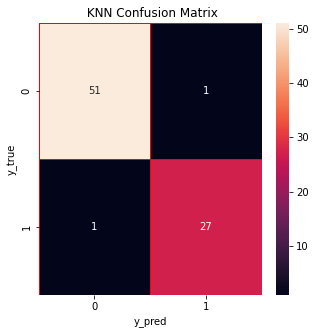

KNN accuracy = 97.5
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        52
         1.0       0.96      0.96      0.96        28

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



In [182]:

from sklearn.metrics import precision_score,accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


from sklearn.neighbors import KNeighborsClassifier

X =  df.drop(['class'], axis=1)
y = df['class']
#Diviser les données (80% Apprentissage et 20% Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)
knn.predict(X_test)


#Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred=knn.predict(X_test)
y_true=y_test
cm=confusion_matrix(y_true,y_pred)

#Confusion Matrix on Heatmap
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title(" KNN Confusion Matrix")
plt.show()

print("KNN accuracy =",knn.score(X_test,y_test)*100)
print(classification_report(y_test,y_pred))

In [183]:
#knn profa houni tebda l partie l behya 
X =  df.drop(['class'], axis=1)
y = df['class']
#Diviser les données (80% Apprentissage et 20% Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Text(0, 0.5, 'Erreur')

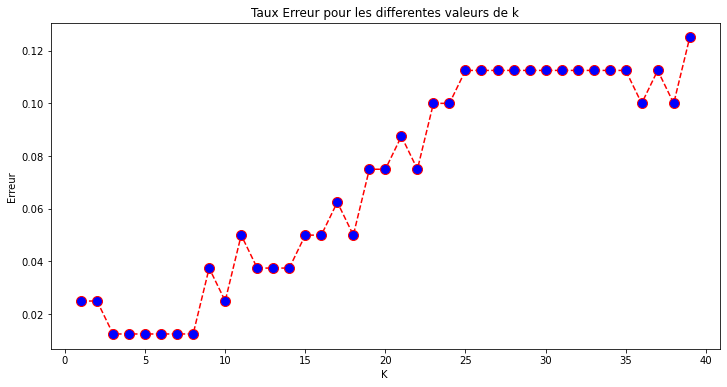

In [184]:
from sklearn.neighbors import KNeighborsClassifier

error = []
# Calculer l'erreur pour k entre 1 et 40 
#Pour chaque itération, l'err²eur moyenne pour les valeurs prédites 
#de l'ensemble de test est calculée et sauvegardée ds la liste Erreur.
# Tester k de 1 à 40 et la distance Manhattan
for i in range(1, 40):
    knn = KNeighborsClassifier(i,metric='manhattan')
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [185]:
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(1,100))
p=[1,2] #p = 1 manhattan_distance/p=2 euclidean_distance
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#cv: number of folds of the cross validation

#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best p: 2
Best n_neighbors: 2


In [186]:
# Afficher les paramètres qui donnent les meilleurs performances
best_parameters = clf.best_params_
print(best_parameters)

{'n_neighbors': 2, 'p': 2}


In [187]:
#Taux de bonne classification
best_result = clf.best_score_
print(best_result)

0.9875


In [188]:
knn = KNeighborsClassifier(2,p=2)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

In [189]:
print('Accuracy of K-NN classifier on test set: {:.3f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on test set: 0.975


In [190]:
score=[] 
algorithms=[] 
precision=[]
sensitivity=[]
recall=[]
f1score=[]

# from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score,accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import sensitivity_score


# y=new_data_clean['class'].values
# x_data=new_data_clean.drop(['class'],axis=1)
# X=(x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))


# X = df_imputed.drop('class', axis=1)
# y = df_imputed['class']


# nb = GaussianNB()
# nb.fit(X_train,y_train)

# #Confusion Matrix 
# from sklearn.metrics import confusion_matrix
# y_pred=nb.predict(X_test)
# y_true=y_test
# cm=confusion_matrix(y_true,y_pred)

# #Confusion Matrix on Heatmap
# f,ax=plt.subplots(figsize=(5,5))
# sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
# plt.xlabel("y_pred")
# plt.ylabel("y_true")
# plt.title("Naive Bayes Confusion Matrix")
# plt.show()

# print("Naive Bayes accuracy =",nb.score(X_test,y_test)*100)
# score.append(nb.score(X_test,y_test)*100)
# algorithms.append("Naive Bayes")

# print("Naive Bayes precision =",precision_score(y_true, y_pred,average = 'macro')*100)
# precision.append(precision_score(y_true, y_pred,average = 'macro')*100)

# print("Naive Bayes sensitivity =",sensitivity_score(y_true, y_pred,average = 'macro')*100)
# sensitivity.append(sensitivity_score(y_true, y_pred,average = 'macro')*100)

# print("Naive Bayes recall =",recall_score(y_true, y_pred,average = 'macro')*100)
# recall.append(recall_score(y_true, y_pred,average = 'macro')*100)

# print("Naive Bayes f1 score =",f1_score(y_true, y_pred,average = 'binary')*100)
# f1score.append(f1_score(y_true, y_pred,average = 'binary')*100)








## New Naive Bayes

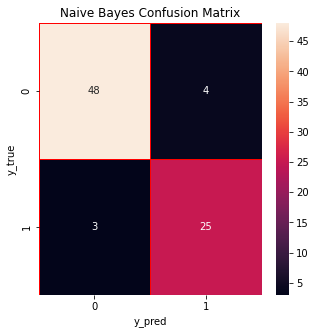

Naive Bayes accuracy = 91.25
Naive Bayes precision = 90.16227180527383
Naive Bayes sensitivity = 90.79670329670331
Naive Bayes recall = 90.79670329670331
Naive Bayes f1 score = 87.71929824561403


In [191]:


from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,y_train)

#Confusion Matrix 
from sklearn.metrics import confusion_matrix
y_pred=nb.predict(X_test)
y_true=y_test
cm=confusion_matrix(y_true,y_pred)

#Confusion Matrix on Heatmap
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

print("Naive Bayes accuracy =",nb.score(X_test,y_test)*100)
score.append(nb.score(X_test,y_test)*100)
algorithms.append("Naive Bayes")

print("Naive Bayes precision =",precision_score(y_true, y_pred,average = 'macro')*100)
precision.append(precision_score(y_true, y_pred,average = 'macro')*100)

print("Naive Bayes sensitivity =",sensitivity_score(y_true, y_pred,average = 'macro')*100)
sensitivity.append(sensitivity_score(y_true, y_pred,average = 'macro')*100)

print("Naive Bayes recall =",recall_score(y_true, y_pred,average = 'macro')*100)
recall.append(recall_score(y_true, y_pred,average = 'macro')*100)

print("Naive Bayes f1 score =",f1_score(y_true, y_pred,average = 'binary')*100)
f1score.append(f1_score(y_true, y_pred,average = 'binary')*100)


#**************************************** NEW METHOD NAIEVE BAYES *************************
# classifier = GaussianNB()
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix, accuracy_score
# ac = accuracy_score(y_test,y_pred)
# cm = confusion_matrix(y_test, y_pred)
# print(ac)


In [192]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
support_vector_machine_model=SVC(random_state=0)
parameters_grid={'kernel':['rbf'],
                'C':[0.1]}
svm_grid_search=GridSearchCV(support_vector_machine_model,parameters_grid,scoring='accuracy')
svm_grid_search.fit(X_train,y_train)
svm_prediction=svm_grid_search.predict(X_test)
print('prediction\n'+str(metrics.precision_score(y_test,svm_prediction)))
print('accurancy\n'+str(metrics.accuracy_score(y_test,svm_prediction)))

prediction
0.9310344827586207
accurancy
0.9625


## CFS

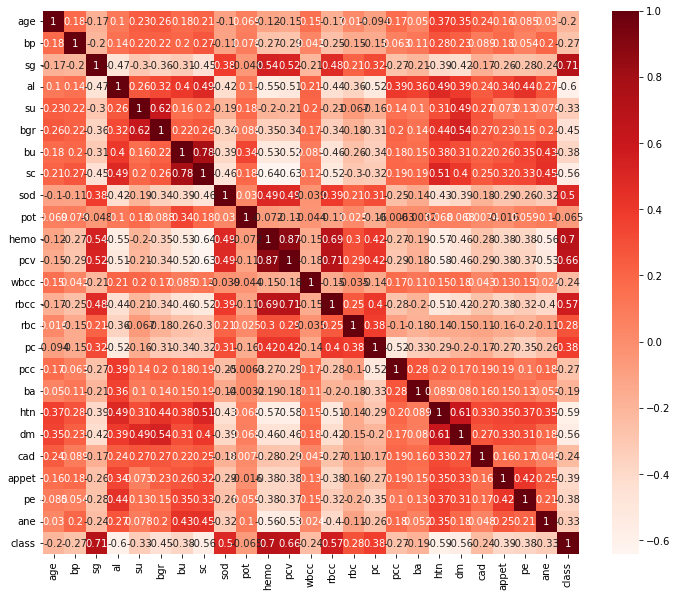

In [193]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [194]:
df.columns


Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [195]:
from scipy.stats import pointbiserialr
from math import sqrt

def getMerit(subset, label):
    k = len(subset)

    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr( df[label], df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )

    # average feature-feature correlation
    corr = df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [196]:
label = 'class'
df.columns
features = df.columns.tolist()
features.remove(label)

In [197]:
subset = [features[1], features[2], features[3], features[4]]
corr = df[subset].corr()
corr.values[np.tril_indices_from(corr.values)] = np.nan
corr

,bp,sg,al,su
bp,NaN,-0.2043,0.142782,0.218342
sg,NaN,NaN,-0.466080,-0.298683
al,NaN,NaN,NaN,0.259016
su,NaN,NaN,NaN,NaN


In [198]:
best_value = -1
best_feature = ''
for feature in features:
    coeff = pointbiserialr( df[label], df[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))

Feature sg with merit 0.7098


In [ ]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        """
        item already in priority queue with smaller priority:
        -> update its priority
        item already in priority queue with higher priority:
        -> do nothing
        if item not in priority queue:
        -> push it
        """
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

In [ ]:
queue = PriorityQueue()
# push first tuple (subset, merit)
queue.push([best_feature], best_value)
# list for visited nodes
visited = []
temp_subset=[]

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 1000


In [ ]:
# repeat until queue is empty
# or the maximum number of backtracks is reached
while len(temp_subset)!=17:
    # get element of queue with highest merit
    subset, priority = queue.pop()

    # check whether the priority of this subset
    # is higher than the current best subset
    if (priority< best_value):
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # goal condition
    #if (n_backtrack == max_backtrack):
        #break
    
    # iterate through all features and look of one can
    # increase the merit
    for feature in features:
        temp_subset = subset + [feature]
        
        # check if this subset has already been evaluated
        for node in visited:
            if (set(node) == set(temp_subset)):
                break
        # if not, ...
        else:
            # ... mark it as visited
            visited.append( temp_subset )
            # ... compute merit
            merit = getMerit(temp_subset, label)
            # and push it to the queue
            queue.push(temp_subset, merit)

In [ ]:
n_backtrack

In [ ]:
temp_subset

In [ ]:
best_subset

In [ ]:
moo=new_data[temp_subset]


In [ ]:
moo.describe()

In [ ]:
X =  moo
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



# NAIVE BAYES WITH CFS

In [ ]:

nb = GaussianNB()
nb.fit(X_train,y_train)

#Confusion Matrix 
from sklearn.metrics import confusion_matrix
y_pred=nb.predict(X_test)
y_true=y_test
cm=confusion_matrix(y_true,y_pred)

#Confusion Matrix on Heatmap
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

print("Naive Bayes accuracy =",nb.score(X_test,y_test)*100)
score.append(nb.score(X_test,y_test)*100)
algorithms.append("Naive Bayes")

print("Naive Bayes precision =",precision_score(y_true, y_pred,average = 'macro')*100)
precision.append(precision_score(y_true, y_pred,average = 'macro')*100)

print("Naive Bayes sensitivity =",sensitivity_score(y_true, y_pred,average = 'macro')*100)
sensitivity.append(sensitivity_score(y_true, y_pred,average = 'macro')*100)

print("Naive Bayes recall =",recall_score(y_true, y_pred,average = 'macro')*100)
recall.append(recall_score(y_true, y_pred,average = 'macro')*100)

print("Naive Bayes f1 score =",f1_score(y_true, y_pred,average = 'binary')*100)
f1score.append(f1_score(y_true, y_pred,average = 'binary')*100)

#************************ NEW METHOD NAIEVE BAYES *********************
# classifier = GaussianNB()
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix, accuracy_score
# ac = accuracy_score(y_test,y_pred)
# cm = confusion_matrix(y_test, y_pred)
# print(ac)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
support_vector_machine_model=SVC(random_state=0)
parameters_grid={'kernel':['rbf'],
                'C':[0.1]}
svm_grid_search=GridSearchCV(support_vector_machine_model,parameters_grid,scoring='accuracy')
svm_grid_search.fit(X_train,y_train)
svm_prediction=svm_grid_search.predict(X_test)
print('prediction\n'+str(metrics.precision_score(y_test,svm_prediction)))
print('accurancy\n'+str(metrics.accuracy_score(y_test,svm_prediction)))